# Project: Multigrid Methods

In this project we will learn three ways of implementating multigrid
methods: from matrix-free to matrix-only depending on how
much information on the grid and PDE is provided. 

Reference
- [Introduction to Multigrid Methods](http://www.math.uci.edu/~chenlong/226/MGintroduction.pdf)
- [Progamming of Multigrid Methods](http://www.math.uci.edu/~chenlong/226/MGcode.pdf)

## Multigrid on Uniform Grids for Poisson Equations

We consider the linear finite element or equivalently 5-point stencil
discretization of the Poisson equation on a uniform grid of $[0,1]^2$ with
size $h$. For simplicity, we assume $h = 1/2^L$ and zero Dirichlet bounary
condition.

### Step 1. Smoother

* Code the weighted Jacobi and the Gauss-Seidel smoother using the matrix-free style; see [Project: Finite Difference Methods](projectFDM.html)

* Check convergence of the Gauss-Seidel smoother by solving $-\Delta u = 1$
  in $(0,1)^2$ with zero Dirichlet boundary condition. Plot the error in a suitable norm vs the iteration step for a fixed `h = 1/16`.

* Change `h` from `1/4` to `1/128` and compare the iteration steps to drive the relative error  below the discretiztion error $h^2$.

* Choose a random initial guess and plot the error function on the grid `h = 1/16` for the first 3 steps.

* (Optional) Code the red-black Gauss-Seidel.

### Step 2. Two-Grid method

* Figure out the index map between fine grid with size `h` and coarse grid with size `2h`. For example, `(i,j)` in the coarse grid is `(2*i-1,2*j-1)` in the fine grid.

* Code the bilinear prolongation and restriction using the index map. Be carefuly on the value on the boundary points.

* Code the two-grid method. On the fine grid, apply m times G-S iteration and then restrict the updated residual to the coarse grid. On the coarse grid, use G-S iteration or the direct method to solve the equation below the discretization error. Then prolongates the correction to the fine grid and apply additional m G-S iterations.

* Use the two-grid method as an iteration to solve the Poisson equation.

* Change `h` from `1/4` to `1/128` and compare the iterations of two-grid methods for different h.

### Step 3. V-cycle Multi-grid method

 Choose one of the following approach to implement the MG.

* (Recrusive way) Apply the two-grid method to the coarse grid problem in Step 2.

* (Non-recrusive way) Follow the description of SSC in lecture notes to implement V-cycle.

* Use the Vcycle as an iteration to solve the Poisson equation, i.e.,
```
    while relative residual < tol
         u = u + Vcycle(r,J); % correction form
         or
         u = Vcycle(u,J); % direct update form
     end
```
* Change `h` from `1/4` to `1/128` and check the iterations and cpu time of MG.

## Multigrid on Hierarchical Grids

We consider the linear finite element discretization of the Poisson equation
on grids obtained by uniform refinement of a coarse grid.

 - Min quality 0.8507 - Mean quality 0.9612 - Uniformity 3.93% 


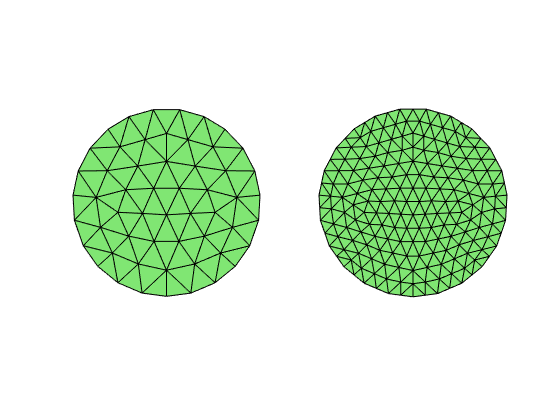

In [2]:
[node,elem] = circlemesh(0,0,1,0.25);
subplot(1,2,1); showmesh(node,elem);
[node,elem] = uniformrefine(node,elem);
subplot(1,2,2); showmesh(node,elem);

### Step 1. Hierarchical Meshes

Generate the initial grid by 

    [node,elem] = circlemesh(0,0,1,0.25);

* Refine the initial mesh `J` times to get the finest mesh. To get a mesh of the disk, the boundary nodes should be projected onto the unit circle.

* Construct `HB` in two ways. Either from the output of `uniformrefine` during the refinement or call `uniformcoarsenred` from the finest mesh.

### Step 2. Transfer Operator and Smoothers

* Assemble the stiffness matrix A in the finest mesh.

* Construct prolongation and restriction matrices using `HB`.

* Compute stiffness matrix in each level by the triple product.

* Store the smoother tril(A) and triu(A) in each level.

### Step 3. V-cycle Multigrid

* Follow the lecture notes [Introduction to Multigrid method](http://math.uci.edu/~chenlong/226/MGintroduction.pdf) to implement the non-recrusive V-cycle.

    _Be careful on the boundary nodes. Restrict smoothing to interiori nodes only and enforce the residual on boundary nodes to be zero._

* For one single grid, say `J = 4`, show the decrease of the residual in certain norm for each iteration of the multigrid method.

* Test V-cycle MG for `J = 3:6`. List iteration steps and cpu time.

## Algebraic Multigrid Methods

We consider solving an SPD matrix equation `Ax = b`, where `A` could be
obtained as the finite element discretization on a unstructured grids. A
coarsening of the graph of A is needed and restriction and prolongation
can be constructued based on the coarsening.

### Step 1 Matrix

* Load the `lakemesh.mat` in ifem/data.

* Assemble the stiffness matrix on this mesh and take the submatrix associated to interior nodes only.

     _The mesh is only used to generate the matrix. In the later step, only the generated matrix is used._

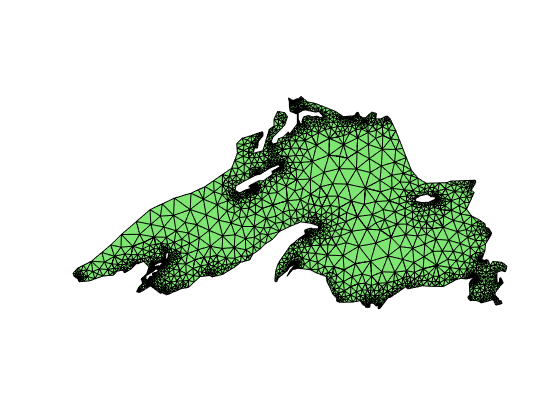

In [3]:
load lakemesh.mat;
figure; clf; showmesh(node,elem);
A = assemblematrix(node,elem);

### Step 2 Coarsening
Use `coarsenAMGc` to get a set of coarse nodes. 

In [4]:
help coarsenAMGc

  COARSENAMGC coarsen the graph of A.
 
  isC = coarsenAMGc(A) terturns a logical array to make a set of nodes as
  the coarse ndoes based on As, a strong connectness matrix modified from
  A. The strong connectness is slightly different with the standard
  definition.
 
  [isC,As] = coarsenAMGc(A,theta) accepts the parameter theta to define the
  strong connectness. The default setting is theta = 0.025. It also outputs
  the strong connectness matrix As which could be used in the constrction
  of prolongation and restriction.
 
  Example
    load lakemesh
    A = assemblematrix(node,elem);
    [isC,As] = coarsenAMGc(A);
 
  See also: coarsenAMGrs, interpolationAMGs, amg
 
  Reference page in Help browser
        <a href="matlab:ifem coarseAMGdoc">coarsenAMGdoc</a> 
 
  Copyright (C) Long Chen. See COPYRIGHT.txt for details. 



### Step 3 Transfer Operator and Smoothers

Use `interpolationAMGs` to get restriction and prolongation operators.

In [1]:
help interpolationAMGs

  INTERPOLATIONAMGS construct prolongation and restriction matrices
 
  [Pro,Res] = interpolatoinAMGs(A,isC) construct prolongation and
  restriction matrices use standard matrix-dependent interpolation. 
 
  In the input, A is a SPD matrix and isC is a logical array to indicate
  nodes in coarse matrix. In the output Pro and Res are prolongation and
  restriction matrices satisfying Res = Pro'.
 
  The submatrix A_{cf} is used to construct the interpolation of values on
  fine nodes from that of coarse nodes. The weight is normalized to
  preserve the constant.
 
  Example
    load lakemesh
    A = assemblematrix(node,elem);
    [isC,As] = coarsenAMGc(A);
    [Pro,Res] = interpolationAMGs(As,isC);
 
  See also: coarsenAMGc, amg
 
  Copyright (C) Long Chen. See COPYRIGHT.txt for details. 



### Step 4. V-cycle Multigrid used with PCG

Follow the Step 3 in part 2 to code a V-cycle. Then use the V-cycle as a
preconditioner in PCG. 

Test the robustness of the solver, apply `uniformrefine` to a mesh and
generate corresponding matrix. List the iteration steps and CPU time for
different size of matrices.